## Настройки/Гиперпараметры/Импорты

In [3]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from navec import Navec
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, concatenate, Embedding, SimpleRNN, Dropout, Flatten, Reshape
from keras.models import Model
import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1) Очистка данных

In [8]:
data = pd.read_excel("/content/drive/MyDrive/tmp/data/dataset_lenta_labels_sentiment_xls.xlsx", index_col=0)
data

,original data,topics,sentiment
0,жёсткий_санкция анонсировать совет_безопаснос...,политика,NEUTRAL
1,участница китай генерация ссылка банка_развит...,экономика_и_финансы,NEUTRAL
2,кандидат снятие солнечный_система поверхность...,наука_и_техника,NEUTRAL
3,очевидец проходить ссылка сотня вконтакте пра...,происшествия,NEGATIVE
4,произойти_пожар осложняться правоохранительны...,происшествия,NEGATIVE
...,...,...,...
8645,союз_европейский марсел полиция посольство...,спорт,NEUTRAL
8646,падение сотрудник_служба_безопасность авиа...,происшествия,NEGATIVE
8647,выехать руководитель федеральный_трасса дт...,происшествия,NEGATIVE
8648,марсел полиция страна подопечный_леонид_сл...,спорт,NEGATIVE


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8650 entries, 0 to 8649
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   original data  8650 non-null   object
 1   topics         8625 non-null   object
 2   sentiment      8650 non-null   object
dtypes: object(3)
memory usage: 270.3+ KB


In [10]:
data = data[data["original data"].notnull()]
data = data[data["topics"].notnull()]
data = data[data["sentiment"].notnull()]

In [11]:
data = data.reset_index(drop=True)
data

,original data,topics,sentiment
0,жёсткий_санкция анонсировать совет_безопаснос...,политика,NEUTRAL
1,участница китай генерация ссылка банка_развит...,экономика_и_финансы,NEUTRAL
2,кандидат снятие солнечный_система поверхность...,наука_и_техника,NEUTRAL
3,очевидец проходить ссылка сотня вконтакте пра...,происшествия,NEGATIVE
4,произойти_пожар осложняться правоохранительны...,происшествия,NEGATIVE
...,...,...,...
8620,союз_европейский марсел полиция посольство...,спорт,NEUTRAL
8621,падение сотрудник_служба_безопасность авиа...,происшествия,NEGATIVE
8622,выехать руководитель федеральный_трасса дт...,происшествия,NEGATIVE
8623,марсел полиция страна подопечный_леонид_сл...,спорт,NEGATIVE


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8625 entries, 0 to 8624
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   original data  8625 non-null   object
 1   topics         8625 non-null   object
 2   sentiment      8625 non-null   object
dtypes: object(3)
memory usage: 202.3+ KB


In [13]:
data.describe()

,original data,topics,sentiment
count,8625,8625,8625
unique,8625,10,3
top,жёсткий_санкция анонсировать совет_безопаснос...,общество_и_путешествия,NEUTRAL
freq,1,1957,4547


In [14]:
data["topics"].value_counts()

topics
общество_и_путешествия    1957
политика                  1231
спорт                     1022
силовые_структур           863
происшествия               712
экономика_и_финансы        667
медиа                      628
наука_и_техника            580
культура                   499
бизнес                     466
Name: count, dtype: int64

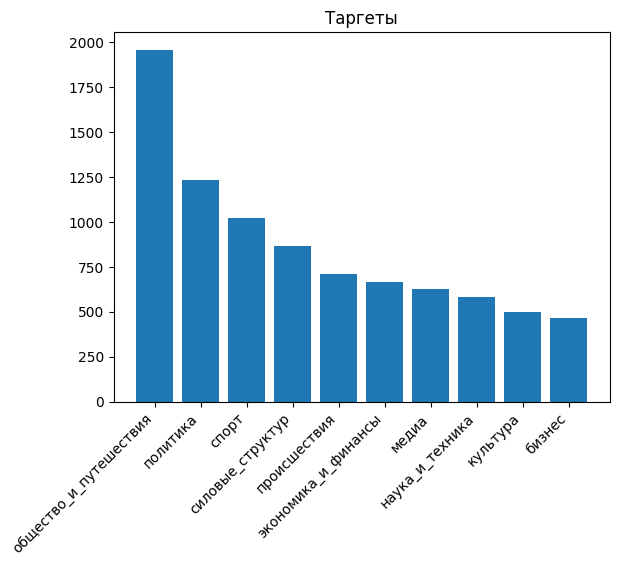

In [15]:
plt.bar(data["topics"].value_counts().index, data["topics"].value_counts())
plt.xticks(rotation=45, ha='right')
plt.title("Таргеты")
plt.show()

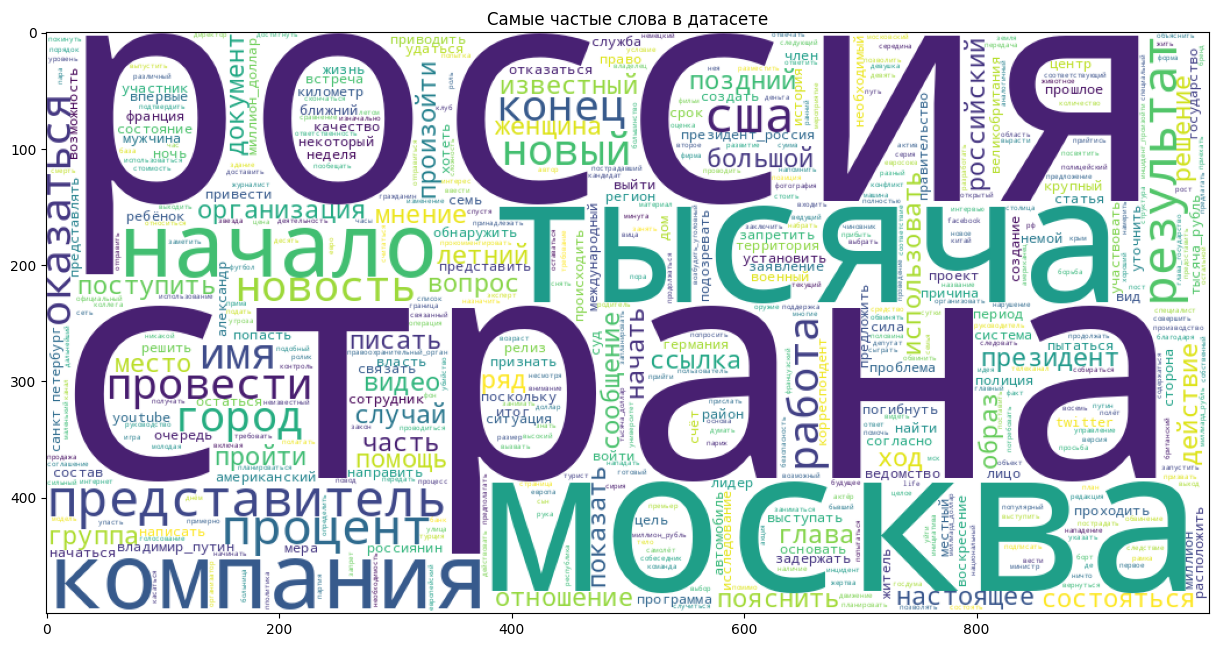

In [16]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=42)
wordcloud.generate(" ".join(data["original data"]))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.title("Самые частые слова в датасете")
plt.show()

### 2) Токенизация

In [17]:
tokenizer = Tokenizer(num_words=None, filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', lower=True, split=" ", char_level=False, oov_token='<OOV>')
tokenizer.fit_on_texts(data['original data'])
encoded_docs = tokenizer.texts_to_sequences(data['original data'])
encoded_docs[0]

[1802,
 201,
 2457,
 132,
 94,
 1850,
 7793,
 2285,
 4,
 11474,
 473,
 328,
 7,
 211,
 757,
 3900,
 184,
 757,
 5082,
 614,
 1120,
 14978,
 132,
 94,
 678,
 308,
 8,
 120,
 1254,
 1730,
 412,
 256,
 1112,
 723,
 111,
 2286,
 3609,
 6127,
 875,
 1680,
 499,
 49,
 69,
 914,
 105,
 351,
 148,
 830,
 1095,
 3693,
 3454,
 64,
 138,
 1641,
 3036,
 329,
 2985,
 3455,
 219,
 848,
 112,
 393,
 43,
 123,
 13,
 4403,
 420,
 1190,
 87,
 968,
 1024,
 323,
 7794,
 595,
 1768,
 7381,
 1046,
 2927,
 10610,
 2642,
 2643,
 351,
 3805,
 678,
 529,
 3154,
 486,
 448,
 2066,
 1945,
 7795,
 2643,
 351,
 58,
 38,
 59,
 1075,
 904,
 242,
 1341,
 225,
 98,
 2986,
 2226,
 1458,
 579,
 289,
 824,
 596,
 4077,
 636,
 1894,
 595,
 50,
 2987,
 609,
 16741,
 2134,
 426,
 75,
 4078,
 961,
 538,
 32,
 463]

In [18]:
print('Число слов в корпусе - ', len(tokenizer.index_word))
tokenizer.index_word

Число слов в корпусе -  19365


{1: '<OOV>',
 2: 'россия',
 3: 'российский',
 4: 'страна',
 5: 'президент',
 6: 'компания',
 7: 'тысяча',
 8: 'сша',
 9: 'глава',
 10: 'москва',
 11: 'место',
 12: 'процент',
 13: 'результат',
 14: 'миллион',
 15: 'рубль',
 16: 'представитель',
 17: 'город',
 18: 'решение',
 19: 'министр',
 20: 'организация',
 21: 'новый',
 22: 'доллар',
 23: 'летний',
 24: 'работа',
 25: 'произойти',
 26: 'большой',
 27: 'отношение',
 28: 'суд',
 29: 'государство',
 30: 'международный',
 31: 'американский',
 32: 'новость',
 33: 'сотрудник',
 34: 'часть',
 35: 'область',
 36: 'имя',
 37: 'группа',
 38: 'провести',
 39: 'полиция',
 40: 'конец',
 41: 'пройти',
 42: 'власть',
 43: 'начало',
 44: 'вопрос',
 45: 'служба',
 46: 'территория',
 47: 'мужчина',
 48: 'мнение',
 49: 'военный',
 50: 'действие',
 51: 'владимир',
 52: 'дом',
 53: 'команда',
 54: 'уголовный',
 55: 'цена',
 56: 'украина',
 57: 'помощь',
 58: 'случай',
 59: 'ряд',
 60: 'московский',
 61: 'официальный',
 62: 'ход',
 63: 'миллиард',
 64: 

In [19]:
lengths = []
for doc in encoded_docs:
    lengths.append(len(doc))

In [20]:
max(lengths)

321

In [21]:
padded_docs = pad_sequences(encoded_docs, maxlen=max(lengths), padding="post", truncating="post", value=0)
padded_docs

array([[ 1802,   201,  2457, ...,     0,     0,     0],
       [ 2534,   458, 14979, ...,     0,     0,     0],
       [  370,  2116,  1946, ...,     0,     0,     0],
       ...,
       [ 2766,   292,   185, ...,     0,     0,     0],
       [ 1767,    39,     4, ...,     0,     0,     0],
       [   34,  2415,    95, ...,     0,     0,     0]], dtype=int32)

In [22]:
padded_docs.shape

(8625, 321)

### 3) Эмбеддинги

In [23]:
navec = Navec.load("/content/drive/MyDrive/tmp/embeddings/navec_news_v1_1B_250K_300d_100q.tar")

In [24]:
embedding_matrix = np.zeros((len(tokenizer.index_word)+1, 300))

for i in range(1, len(tokenizer.index_word)+1):
    word = tokenizer.index_word[i]
    if navec.get(word) is not None:
        embedding_matrix[i] = navec.get(word)

embedding_matrix[100]

array([-0.33270851, -0.07963513, -0.0627134 ,  0.57241243,  0.34684283,
        0.8713361 , -0.10832249, -0.42088002,  0.27392909,  0.70543265,
       -0.04992551, -0.92096812,  0.4961493 ,  0.24743818,  0.08351634,
        0.09935933, -0.29334456,  0.00227916, -0.68371964, -0.04894074,
       -0.18267269, -0.27487913, -0.1559369 , -0.87670988, -0.15656655,
        0.37439832, -0.42305124,  0.22899438, -0.59827161,  0.39030212,
       -0.62797374, -0.01789118,  0.15031494, -0.67939532, -0.21114407,
        0.20663267, -0.37880182,  0.279751  ,  0.53371179,  0.86209488,
        0.54343259, -0.43398401,  0.32512292,  0.50465792, -0.44336349,
       -0.13078916, -0.38289857,  0.04631085, -0.18973543,  0.04149314,
       -0.51170439, -0.20311779,  0.4565841 ,  0.60004711, -0.01592683,
        0.37013027, -0.4033739 ,  0.07143508, -0.15078226,  0.26493177,
        0.32533142, -0.15184319, -0.18352412, -0.12487039,  0.07998284,
       -0.17105985, -0.05239832,  0.42920709,  0.49067116, -0.34

### 4) Подготовка к обучению модели

In [25]:
data_topics = pd.get_dummies(data['topics'])
data_topics

,бизнес,культура,медиа,наука_и_техника,общество_и_путешествия,политика,происшествия,силовые_структур,спорт,экономика_и_финансы
0,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,True
2,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
8620,False,False,False,False,False,False,False,False,True,False
8621,False,False,False,False,False,False,True,False,False,False
8622,False,False,False,False,False,False,True,False,False,False
8623,False,False,False,False,False,False,False,False,True,False


In [26]:
data_sentiment = pd.get_dummies(data['sentiment'])
data_sentiment

,NEGATIVE,NEUTRAL,POSITIVE
0,False,True,False
1,False,True,False
2,False,True,False
3,True,False,False
4,True,False,False
...,...,...,...
8620,False,True,False
8621,True,False,False
8622,True,False,False
8623,True,False,False


In [27]:
columns = [f"Token {i}" for i in range(1, max(lengths)+1)]
print(columns)

['Token 1', 'Token 2', 'Token 3', 'Token 4', 'Token 5', 'Token 6', 'Token 7', 'Token 8', 'Token 9', 'Token 10', 'Token 11', 'Token 12', 'Token 13', 'Token 14', 'Token 15', 'Token 16', 'Token 17', 'Token 18', 'Token 19', 'Token 20', 'Token 21', 'Token 22', 'Token 23', 'Token 24', 'Token 25', 'Token 26', 'Token 27', 'Token 28', 'Token 29', 'Token 30', 'Token 31', 'Token 32', 'Token 33', 'Token 34', 'Token 35', 'Token 36', 'Token 37', 'Token 38', 'Token 39', 'Token 40', 'Token 41', 'Token 42', 'Token 43', 'Token 44', 'Token 45', 'Token 46', 'Token 47', 'Token 48', 'Token 49', 'Token 50', 'Token 51', 'Token 52', 'Token 53', 'Token 54', 'Token 55', 'Token 56', 'Token 57', 'Token 58', 'Token 59', 'Token 60', 'Token 61', 'Token 62', 'Token 63', 'Token 64', 'Token 65', 'Token 66', 'Token 67', 'Token 68', 'Token 69', 'Token 70', 'Token 71', 'Token 72', 'Token 73', 'Token 74', 'Token 75', 'Token 76', 'Token 77', 'Token 78', 'Token 79', 'Token 80', 'Token 81', 'Token 82', 'Token 83', 'Token 84', 

In [28]:
data_X = pd.DataFrame(padded_docs, columns=columns)
data_X = pd.concat([data_X, data_topics], axis=1)
data_X

,Token 1,Token 2,Token 3,Token 4,Token 5,Token 6,Token 7,Token 8,Token 9,Token 10,...,бизнес,культура,медиа,наука_и_техника,общество_и_путешествия,политика,происшествия,силовые_структур,спорт,экономика_и_финансы
0,1802,201,2457,132,94,1850,7793,2285,4,11474,...,False,False,False,False,False,True,False,False,False,False
1,2534,458,14979,67,318,134,79,1787,335,1875,...,False,False,False,False,False,False,False,False,False,True
2,370,2116,1946,71,1895,233,4300,1681,415,273,...,False,False,False,True,False,False,False,False,False,False
3,1459,212,67,1147,1350,155,72,9908,907,2535,...,False,False,False,False,False,False,True,False,False,False
4,25,1057,10615,155,72,1057,250,1788,661,2287,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8620,223,168,1767,39,1890,19,282,3,976,2021,...,False,False,False,False,False,False,False,False,True,False
8621,471,33,45,94,653,1846,1091,1273,1541,579,...,False,False,False,False,False,False,True,False,False,False
8622,2766,292,185,2096,1581,25,8646,586,486,10,...,False,False,False,False,False,False,True,False,False,False
8623,1767,39,4,2021,1419,1820,438,2,18,216,...,False,False,False,False,False,False,False,False,True,False


In [29]:
data_sentiment.value_counts()

NEGATIVE  NEUTRAL  POSITIVE
False     True     False       4547
True      False    False       3944
False     False    True         134
Name: count, dtype: int64

In [30]:
dataset_resample = pd.DataFrame(columns=list(data_X.columns).extend(data_sentiment.columns))
for label_value in data_sentiment.columns:
    dataset_0 = data_X[data['sentiment'] == label_value]
    dataset_0 = resample(dataset_0, replace=True, n_samples=data_sentiment.value_counts()[0], random_state=42)
    data_for_label = pd.DataFrame(dataset_0)
    data_for_label[data_sentiment.columns] = pd.DataFrame([data_sentiment[data['sentiment'] == label_value].iloc[0]], index=data_for_label.index)
    dataset_resample = pd.concat([dataset_resample, data_for_label])

In [31]:
dataset_resample

,Token 1,Token 2,Token 3,Token 4,Token 5,Token 6,Token 7,Token 8,Token 9,Token 10,...,наука_и_техника,общество_и_путешествия,политика,происшествия,силовые_структур,спорт,экономика_и_финансы,NEGATIVE,NEUTRAL,POSITIVE
6884,370,12385,1504,702,443,621,736,1536,77,83,...,False,False,True,False,False,False,False,True,False,False
7646,2084,458,12453,3158,4314,15822,68,4196,1860,5356,...,False,False,True,False,False,False,False,True,False,False
1915,540,103,54,34,485,7,15,133,8787,7440,...,False,False,False,False,True,False,False,True,False,False
2899,133,87,839,7460,2787,18,8015,234,71,272,...,False,False,False,False,False,False,True,True,False,False
2545,49,1292,3283,556,334,56,153,249,2564,3031,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4820,1580,2490,621,14,18197,398,2370,5564,3988,4160,...,False,False,False,False,False,False,False,False,False,True
470,6445,10719,1794,7590,7591,4580,7208,3597,6546,2821,...,False,False,False,False,False,False,False,False,False,True
3235,4851,298,926,4898,5827,800,1004,12602,9135,4,...,False,False,False,False,False,False,False,False,False,True
4849,5425,1434,494,77,153,2712,3644,325,808,4,...,False,True,False,False,False,False,False,False,False,True


In [32]:
dataset_resample['NEGATIVE'].value_counts()

NEGATIVE
False    9094
True     4547
Name: count, dtype: int64

In [33]:
dataset_resample['NEUTRAL'].value_counts()

NEUTRAL
False    9094
True     4547
Name: count, dtype: int64

In [34]:
dataset_resample['POSITIVE'].value_counts()

POSITIVE
False    9094
True     4547
Name: count, dtype: int64

In [35]:
dataset_resample = dataset_resample.sample(frac=1)

In [36]:
dataset_resample

,Token 1,Token 2,Token 3,Token 4,Token 5,Token 6,Token 7,Token 8,Token 9,Token 10,...,наука_и_техника,общество_и_путешествия,политика,происшествия,силовые_структур,спорт,экономика_и_финансы,NEGATIVE,NEUTRAL,POSITIVE
7937,1132,4189,2702,59,772,5710,812,1516,11157,1385,...,False,True,False,False,False,False,False,True,False,False
370,4271,3046,67,355,405,2349,51,73,4523,917,...,False,False,False,False,False,False,False,False,True,False
7121,615,17,133,190,495,38,1819,2370,277,5534,...,False,False,False,False,False,False,False,False,False,True
4775,398,325,302,1767,1919,222,820,674,137,232,...,False,False,False,False,False,True,False,True,False,False
844,8072,17,2510,686,516,2348,3072,2415,6292,3,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,370,516,1003,171,38,87,4685,4435,79,6560,...,False,False,True,False,False,False,False,False,True,False
125,357,807,17,4668,394,110,2081,1070,171,714,...,True,False,False,False,False,False,False,True,False,False
8076,2211,11667,523,488,7823,562,3152,343,174,3022,...,False,True,False,False,False,False,False,False,False,True
8502,2009,6744,948,43,7855,398,1516,13651,2024,37,...,False,False,False,False,False,False,False,False,False,True


In [37]:
data_sentiment = dataset_resample[data_sentiment.columns]
data_sentiment

,NEGATIVE,NEUTRAL,POSITIVE
7937,True,False,False
370,False,True,False
7121,False,False,True
4775,True,False,False
844,False,False,True
...,...,...,...
3952,False,True,False
125,True,False,False
8076,False,False,True
8502,False,False,True


In [38]:
dataset_resample.drop(data_sentiment.columns, axis=1, inplace=True)
dataset_resample

,Token 1,Token 2,Token 3,Token 4,Token 5,Token 6,Token 7,Token 8,Token 9,Token 10,...,бизнес,культура,медиа,наука_и_техника,общество_и_путешествия,политика,происшествия,силовые_структур,спорт,экономика_и_финансы
7937,1132,4189,2702,59,772,5710,812,1516,11157,1385,...,False,False,False,False,True,False,False,False,False,False
370,4271,3046,67,355,405,2349,51,73,4523,917,...,False,False,True,False,False,False,False,False,False,False
7121,615,17,133,190,495,38,1819,2370,277,5534,...,False,False,True,False,False,False,False,False,False,False
4775,398,325,302,1767,1919,222,820,674,137,232,...,False,False,False,False,False,False,False,False,True,False
844,8072,17,2510,686,516,2348,3072,2415,6292,3,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,370,516,1003,171,38,87,4685,4435,79,6560,...,False,False,False,False,False,True,False,False,False,False
125,357,807,17,4668,394,110,2081,1070,171,714,...,False,False,False,True,False,False,False,False,False,False
8076,2211,11667,523,488,7823,562,3152,343,174,3022,...,False,False,False,False,True,False,False,False,False,False
8502,2009,6744,948,43,7855,398,1516,13651,2024,37,...,False,True,False,False,False,False,False,False,False,False


In [39]:
data_y = data_sentiment
data_X = dataset_resample
print(data_y.shape, '\n', data_X.shape)

(13641, 3) 
 (13641, 331)


### 5) Обучение модели

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=42, stratify=data_y, shuffle=True)

In [41]:
columns_input_1 = X_train.columns[:max(lengths)]
columns_input_2 = X_train.columns[max(lengths):]


X_train_1 = X_train[columns_input_1].values.astype(np.float32)
X_train_2 = X_train[columns_input_2].values.astype(np.float32)
y_train = y_train.values.astype(np.float32)

X_test_1 = X_test[columns_input_1].values.astype(np.float32)
X_test_2 = X_test[columns_input_2].values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

In [42]:
X_train

,Token 1,Token 2,Token 3,Token 4,Token 5,Token 6,Token 7,Token 8,Token 9,Token 10,...,бизнес,культура,медиа,наука_и_техника,общество_и_путешествия,политика,происшествия,силовые_структур,спорт,экономика_и_финансы
5754,7463,593,323,3458,6188,2830,1606,832,117,344,...,False,False,False,False,False,True,False,False,False,False
2256,69,212,548,179,355,1672,66,2335,8576,301,...,False,False,False,False,True,False,False,False,False,False
1277,227,46,2,311,2512,1551,2853,1012,12827,4321,...,False,False,False,False,True,False,False,False,False,False
892,309,2801,4365,8,146,55,4747,304,15,9632,...,False,False,False,False,False,False,False,False,False,True
7233,516,2157,3,408,3103,9,6673,1630,7414,355,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6605,2084,298,394,220,6678,11443,711,8161,174,82,...,False,False,False,False,True,False,False,False,False,False
4732,7337,2961,3419,2,142,37,1299,2150,7241,1614,...,False,True,False,False,False,False,False,False,False,False
6673,298,1073,7337,1002,5043,11255,345,135,90,86,...,False,False,False,False,True,False,False,False,False,False
210,8354,2534,17,1128,440,394,553,203,151,1850,...,False,False,False,False,True,False,False,False,False,False


In [43]:
print(X_train_1, '\n', X_train_1.shape)

[[7.463e+03 5.930e+02 3.230e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 [6.900e+01 2.120e+02 5.480e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.270e+02 4.600e+01 2.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [2.980e+02 1.073e+03 7.337e+03 ... 0.000e+00 0.000e+00 0.000e+00]
 [8.354e+03 2.534e+03 1.700e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [6.700e+01 6.390e+02 1.118e+03 ... 0.000e+00 0.000e+00 0.000e+00]] 
 (10912, 321)


In [44]:
print(X_train_2, '\n', X_train_2.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]] 
 (10912, 10)


In [45]:
print(y_train, '\n', y_train.shape)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]] 
 (10912, 3)


In [46]:
text_input_size = max(lengths)
topic_input_size = len(columns_input_2)

In [55]:
layer_input_1 = Input(shape=(text_input_size,), dtype=np.float32)
layer_embedding = Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=300, input_length=text_input_size)(layer_input_1)

layer_rnn_1 = SimpleRNN(units=256, activation=None, return_sequences=True)(layer_embedding)
layer_rnn_2 = SimpleRNN(units=128, activation="tanh", return_sequences=False)(layer_rnn_1)
layer_linear_1_1 = Dense(units=64, activation=None)(layer_rnn_2)
layer_linear_1_2 = Dense(units=32, activation="relu")(layer_linear_1_1)
model_1 = Model(inputs=layer_input_1, outputs=layer_linear_1_2)

layer_input_2 = Input(shape=(topic_input_size,), dtype=np.float32)
layer_linear_2_1 = Dense(units=256, activation=None)(layer_input_2)
layer_linear_2_2 = Dense(units=128, activation=None)(layer_linear_2_1)
layer_linear_2_3 = Dense(units=64, activation=None)(layer_linear_2_2)
layer_linear_2_4 = Dense(units=32, activation="relu")(layer_linear_2_3)
model_2 = Model(inputs=layer_input_2, outputs=layer_linear_2_4)

combined = concatenate([model_1.output, model_2.output])
layer_linear_3_1 = Dense(units=128, activation=None)(combined)
layer_dropout = Dropout(rate=0.1)(layer_linear_3_1)
layer_linear_3_2 = Dense(units=64, activation="relu")(layer_dropout)
layer_output = Dense(units=3, activation="softmax")(layer_linear_3_2)
model = Model(inputs=[model_1.input, model_2.input], outputs=layer_output)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 321)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 321, 300)             5809800   ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 simple_rnn_2 (SimpleRNN)    (None, 321, 256)             142592    ['embedding_1[0][0]']         
                                                                                            

In [56]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

In [57]:
optimizer = keras.optimizers.Adam(learning_rate=0.0003)

In [58]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
time_start = time.time()

history = model.fit(x=[X_train_1, X_train_2], y=y_train, epochs=80, batch_size=32, validation_data=([X_test_1, X_test_2], y_test), verbose=1)

print(f"Время, затраченное на обучение: {time.time()  - time_start} секунд.")

Epoch 1/80
341/341 [==============================] - 136s 386ms/step - loss: 1.0126 - accuracy: 0.4728 - val_loss: 0.9702 - val_accuracy: 0.5009
Epoch 2/80
341/341 [==============================] - 139s 409ms/step - loss: 0.9450 - accuracy: 0.5319 - val_loss: 0.9358 - val_accuracy: 0.5394
Epoch 3/80
341/341 [==============================] - 141s 414ms/step - loss: 0.9030 - accuracy: 0.5588 - val_loss: 0.8945 - val_accuracy: 0.5603
Epoch 4/80
341/341 [==============================] - 136s 399ms/step - loss: 0.8687 - accuracy: 0.5815 - val_loss: 0.8669 - val_accuracy: 0.5709
Epoch 5/80
341/341 [==============================] - 136s 399ms/step - loss: 0.8350 - accuracy: 0.6033 - val_loss: 0.8515 - val_accuracy: 0.5727
Epoch 6/80
341/341 [==============================] - 139s 407ms/step - loss: 0.8053 - accuracy: 0.6180 - val_loss: 0.8282 - val_accuracy: 0.5863
Epoch 7/80
341/341 [==============================] - 138s 405ms/step - loss: 0.7842 - accuracy: 0.6288 - val_loss: 0.8025 -

In [61]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [62]:
#model.save("./models/final_model_tokens.keras")
model.save("/content/drive/MyDrive/tmp/models/final_model_tokens.keras")

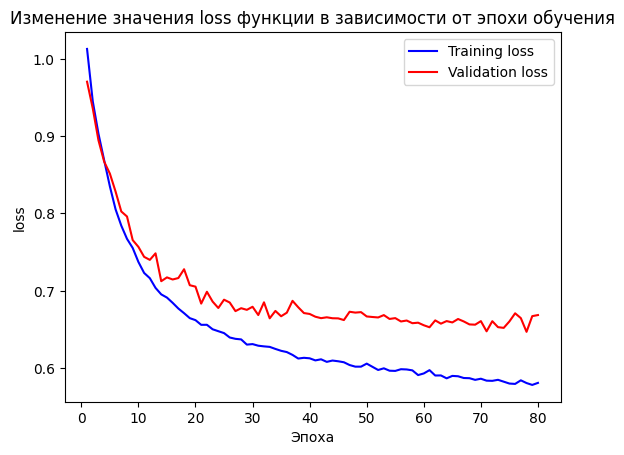

In [63]:
loss_train = history_dict['loss']
loss_val = history_dict['val_loss']
epochs = range(1, len(history_dict['loss']) + 1)
plt.plot(epochs, loss_train, 'b', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='Validation loss')
plt.title("Изменение значения loss функции в зависимости от эпохи обучения")
plt.xlabel('Эпоха')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
#model = keras.models.load_model("./models/final_model_tokens.keras")

In [64]:
y_pred = model.predict([X_test_1, X_test_2])
print(y_pred.shape)

86/86 [==============================] - 5s 51ms/step
(2729, 3)


In [65]:
y_pred

array([[5.3695929e-01, 4.6304044e-01, 3.0880966e-07],
       [1.4691719e-01, 8.4697455e-01, 6.1081839e-03],
       [3.1796405e-01, 6.7887640e-01, 3.1595682e-03],
       ...,
       [2.0141113e-01, 3.0460021e-01, 4.9398866e-01],
       [5.2464497e-01, 3.8882825e-01, 8.6526744e-02],
       [5.3031021e-01, 4.6968919e-01, 6.5311110e-07]], dtype=float32)

In [66]:
y_test = pd.DataFrame(y_test, columns=data_sentiment.columns)
y_pred = pd.DataFrame(y_pred, columns=data_sentiment.columns)
y_pred

,NEGATIVE,NEUTRAL,POSITIVE
0,0.536959,0.463040,3.088097e-07
1,0.146917,0.846975,6.108184e-03
2,0.317964,0.678876,3.159568e-03
3,0.627830,0.371956,2.138944e-04
4,0.095020,0.024220,8.807603e-01
...,...,...,...
2724,0.479176,0.512169,8.654837e-03
2725,0.149023,0.187836,6.631417e-01
2726,0.201411,0.304600,4.939887e-01
2727,0.524645,0.388828,8.652674e-02


In [67]:
y_test = y_test.idxmax(axis=1)
y_pred = y_pred.idxmax(axis=1)
y_pred

0       NEGATIVE
1        NEUTRAL
2        NEUTRAL
3       NEGATIVE
4       POSITIVE
          ...   
2724     NEUTRAL
2725    POSITIVE
2726    POSITIVE
2727    NEGATIVE
2728    NEGATIVE
Length: 2729, dtype: object

In [68]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

    NEGATIVE       0.59      0.55      0.57       910
     NEUTRAL       0.62      0.53      0.57       910
    POSITIVE       0.80      0.97      0.88       909

    accuracy                           0.68      2729
   macro avg       0.67      0.68      0.67      2729
weighted avg       0.67      0.68      0.67      2729

